# ML BATTLE ROYAL - PREDICT HEALTH OUTCOMES OF HORSES

Parts of our notebook: 
* Data Load 
* Exploratory Data Analysis
* Data Visualization
* Preprocessing
* Modelling
* Submission

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import contextlib
import os
import sys

from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder

C:\Users\Satriock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [2]:
train = pd.read_csv(r"./../../data/raw/train.csv")
test = pd.read_csv(r"./../../data/raw/test.csv")

# Exploratory Data Analysis

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [4]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
train.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [6]:
train.isnull().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

# Data Visualization

C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\4201091745.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data_test[col], ax=axes[i, 0], label='Test', color=color_test)


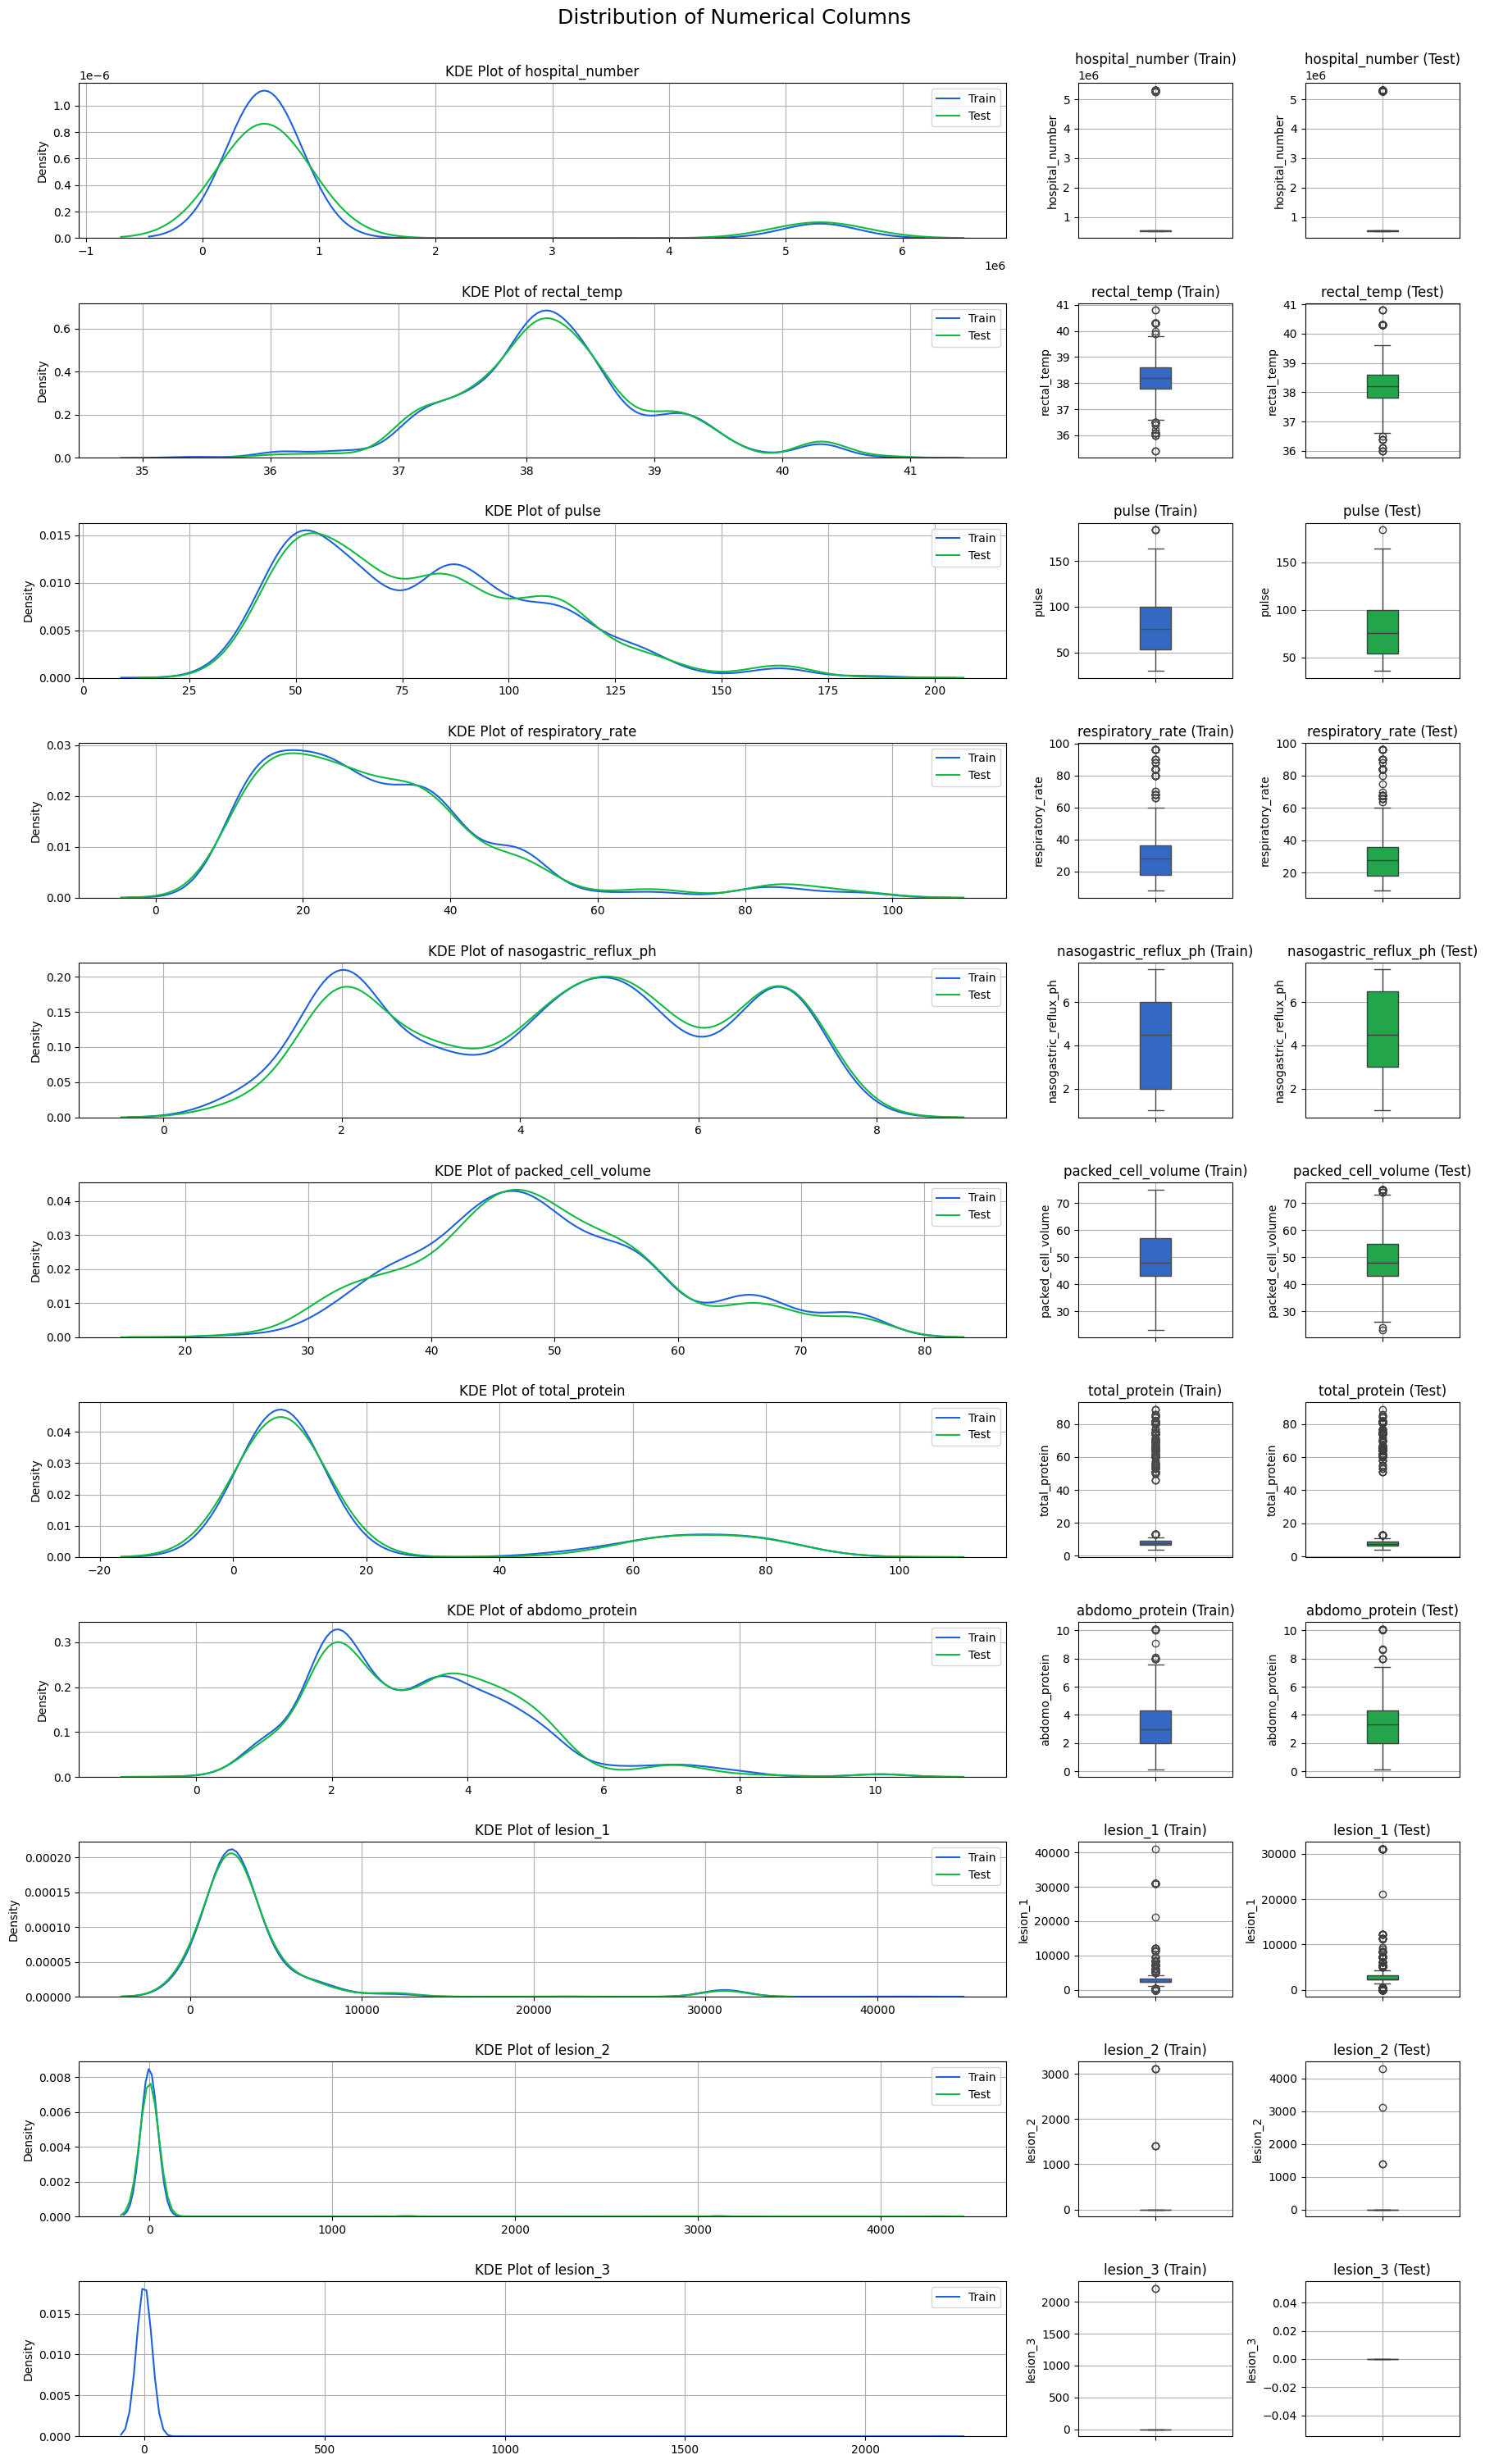

In [7]:
data_train = train.drop(columns=['outcome', 'id'])
data_test = test.drop(columns=['id'])
num_cols = data_train.select_dtypes(include='number').columns

color_train = '#1D62DA'
color_test = '#10BA43'

fig, axes = plt.subplots(len(num_cols), 3, figsize=(18, 30), gridspec_kw={'width_ratios': [0.90, 0.15, 0.15]})

for i, col in enumerate(num_cols):
    # KDE plot
    sns.kdeplot(data=data_train[col], ax=axes[i, 0], label='Train', color=color_train)
    sns.kdeplot(data=data_test[col], ax=axes[i, 0], label='Test', color=color_test)
    axes[i, 0].grid(True)
    axes[i, 0].set_title('KDE Plot of ' + col)
    axes[i, 0].set_xlabel('')
    axes[i, 0].legend()

    # Boxplot untuk data train
    sns.boxplot(y=col, data=data_train, ax=axes[i, 1], color=color_train, width=0.2)
    axes[i, 1].grid(True)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(col + ' (Train)')

    # Boxplot untuk data test
    sns.boxplot(y=col, data=data_test, ax=axes[i, 2], color=color_test, width=0.2)
    axes[i, 2].grid(True)
    axes[i, 2].set_xlabel('')
    axes[i, 2].set_title(col + ' (Test)')

plt.suptitle('Distribution of Numerical Columns', fontsize=18, y=1)
plt.tight_layout()
plt.show()

C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\3577316964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outcome', data=train, palette='viridis')


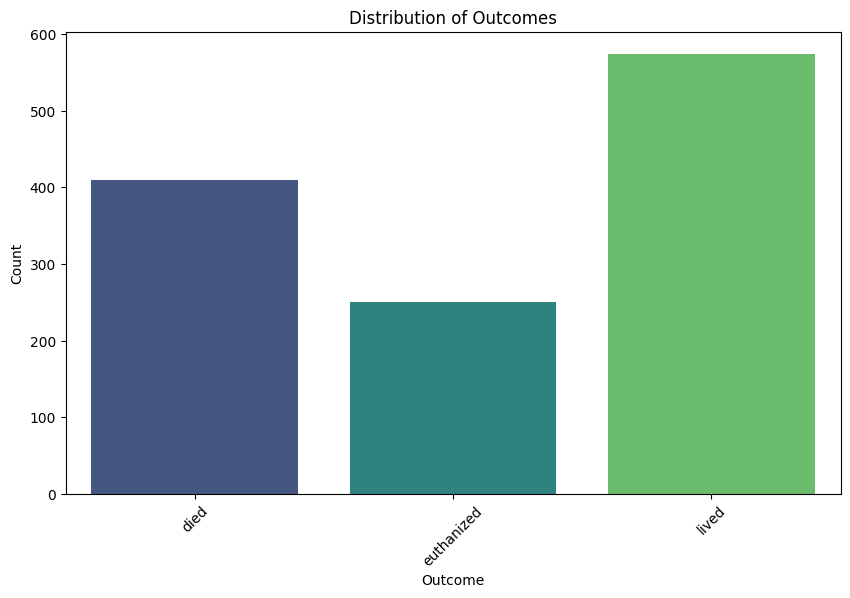

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome', data=train, palette='viridis')
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Preprocessing

In [9]:
def replace_missing_with_most_common(data, columns):
    for column in columns:
        col_most_common = data[column].value_counts().index[0]
        data[column] = data[column].replace({np.nan: col_most_common})
    return data

In [10]:
train_missing_cols = train.columns[train.isnull().any()]
test_missing_cols = test.columns[test.isnull().any()]

train = replace_missing_with_most_common(train, train_missing_cols)
test = replace_missing_with_most_common(test, test_missing_cols)

One hot encoding: replaces categorical values ​​with numeric values ​​for some columns in a dataset

In [11]:
binary_columns = ['surgery', 'age', 'surgical_lesion', 'cp_data']
binary_mappings = {'yes': 1, 'no': 0, 'adult': 1, 'young': 0, 'died': 0, 'euthanized': 1, 'lived': 2}
for col in binary_columns:
    train[col] = train[col].replace(binary_mappings)
    test[col] = test[col].replace(binary_mappings)

In [12]:
columns_to_encode = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
                     'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']

In [13]:
columns_to_encode = [col for col in columns_to_encode if col in train.columns and col in test.columns]

train = pd.get_dummies(data=train, columns=columns_to_encode)
test = pd.get_dummies(data=test, columns=columns_to_encode)

In [14]:
train.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 69, dtype: int64

In [15]:
test.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 65, dtype: int64

In [16]:
train.to_csv('./../../data/processed/cleaned_train1.csv', index=False)
test.to_csv('./../../data/processed/cleaned_test1.csv', index=False)

In [17]:
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test.reindex(columns=train.columns, fill_value=0)

In [18]:
y = train['outcome']
X_id = train['id']
X = train.drop(columns=['outcome', 'id'])

X_test_id = test['id']
X_test = test.drop(columns=['id'])


In [19]:
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [21]:
X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

In [24]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

988 988
247 247


# Modelling

In [25]:
# Fungsi untuk menyembunyikan output
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Menyiapkan model dengan parameter terbaik
models = {
    "LGBM": LGBMClassifier(), 
    "Random Forest": RandomForestClassifier(), 
    "XGB": XGBClassifier(),
    "CatBoost": CatBoostClassifier(),
    "SVC": SVC(probability=True),
    "NB": GaussianNB(),
    "KNN": KNeighborsClassifier() 
}

# Dictionary untuk menyimpan hasil metrik
metrics = {
    'Model': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': []
}

# Melatih model dan menyembunyikan log training
for name, model in models.items():
    with suppress_output():
        model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else 'N/A'
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['ROC AUC'].append(roc_auc)
    metrics['F1 Score'].append(f1)

# Membuat DataFrame dari hasil metrik
metrics_df = pd.DataFrame(metrics)

# Mencetak tabel hasil metrik
metrics_df

,Model,Accuracy,ROC AUC,F1 Score
0,LGBM,0.704453,0.842326,0.704453
1,Random Forest,0.684211,0.845099,0.684211
2,XGB,0.700405,0.846823,0.700405
3,CatBoost,0.720648,0.852928,0.720648
4,SVC,0.700405,0.841003,0.700405
5,NB,0.408907,0.750547,0.408907
6,KNN,0.672065,0.812051,0.672065


### Hyperparameter Tuning

In [26]:
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 350)
    max_depth = trial.suggest_int('max_depth', 10, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    random_state = trial.suggest_int('random_state', 42, 42)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=random_state
    )
    
    clf.fit(X_train, y_train_encoded)

    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

def lgbm_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 350)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 10.0)
    
    clf = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        verbose= -1,
        random_state=42
    )
    
    clf.fit(X_train, y_train_encoded)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

def cb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 350)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 20)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 10.0)
    
    clf = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        colsample_bylevel=colsample_bylevel,
        reg_lambda=reg_lambda,
        random_state=42,
        verbose= False
    )
    
    clf.fit(X_train, y_train_encoded)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 350)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 10.0)
    
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        objective='multi:softmax',
	num_class=3
    )
    
    clf.fit(X_train, y_train_encoded)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

def svm_objective(trial):
    C = trial.suggest_float('C', 1e-2, 1e+2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 2, 5)
    
    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree
    )
    
    clf.fit(X_train, y_train_encoded)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    
    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    
    clf.fit(X_train, y_train_encoded)
    
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    return f1

In [27]:
objectives = [rf_objective, xgb_objective, cb_objective, lgbm_objective, svm_objective, knn_objective]

In [28]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

results = {}

for objective in objectives:
    print(f"Starting optimization for {objective.__name__}...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    
    results[objective.__name__] = {
        'best_params': study.best_params
    }

Starting optimization for rf_objective...
Starting optimization for xgb_objective...


C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:87: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:91: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 10.0)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:92: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_logunif

Starting optimization for cb_objective...


C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:63: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 10.0)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_lo

Starting optimization for lgbm_objective...


C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 10.0)
C:\Users\Satriock\AppData\Local\Temp\ipykernel_17044\1984572471.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_lambda = trial.suggest_logunif

Starting optimization for svm_objective...
Starting optimization for knn_objective...


In [29]:
results

{'rf_objective': {'best_params': {'n_estimators': 249,
   'max_depth': 20,
   'min_samples_split': 7,
   'min_samples_leaf': 5,
   'bootstrap': True,
   'random_state': 42}},
 'xgb_objective': {'best_params': {'n_estimators': 270,
   'max_depth': 8,
   'learning_rate': 0.022572131376636193,
   'min_child_weight': 6,
   'subsample': 0.5075759629685038,
   'colsample_bytree': 0.7888447062352784,
   'reg_alpha': 0.13661253839617987,
   'reg_lambda': 5.291580564016835}},
 'cb_objective': {'best_params': {'n_estimators': 320,
   'max_depth': 7,
   'learning_rate': 0.028437425114277545,
   'min_child_samples': 16,
   'colsample_bylevel': 0.7455274774564526,
   'reg_lambda': 6.36077494078117e-05}},
 'lgbm_objective': {'best_params': {'n_estimators': 295,
   'max_depth': 8,
   'learning_rate': 0.02411088788342028,
   'min_child_samples': 6,
   'subsample': 0.5952008959129844,
   'colsample_bytree': 0.5984772111545175,
   'reg_alpha': 0.0001783955636674523,
   'reg_lambda': 0.007482873457522421

In [30]:
models_tuned = {
    "LGBM": LGBMClassifier(**results['lgbm_objective']['best_params'], random_state=42), 
    "Random Forest": RandomForestClassifier(**results['rf_objective']['best_params']), 
    "XGB": XGBClassifier(**results['xgb_objective']['best_params'], random_state=42, objective='multi:softprob', num_class=3, eval_metric='mlogloss'),
    "CatBoost": CatBoostClassifier(**results['cb_objective']['best_params'], random_state=42, verbose=False),
    "SVC": SVC(**results['svm_objective']['best_params'], probability=True),
    "NB": GaussianNB(),
    "KNN": KNeighborsClassifier(**results['knn_objective']['best_params'],) 
}

In [31]:
metrics = {
    'Model': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': []
}

# Melatih model dan menyembunyikan log training
for name, model in models.items():
    with suppress_output():
        model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else 'N/A'
    f1 = f1_score(y_test_encoded, y_pred, average='micro')
    
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['ROC AUC'].append(roc_auc)
    metrics['F1 Score'].append(f1)

# Membuat DataFrame dari hasil metrik
metrics_df = pd.DataFrame(metrics)

# Mencetak tabel hasil metrik
metrics_df

,Model,Accuracy,ROC AUC,F1 Score
0,LGBM,0.704453,0.842326,0.704453
1,Random Forest,0.692308,0.844277,0.692308
2,XGB,0.700405,0.846823,0.700405
3,CatBoost,0.720648,0.852928,0.720648
4,SVC,0.700405,0.841259,0.700405
5,NB,0.408907,0.750547,0.408907
6,KNN,0.672065,0.812051,0.672065


### K-fold Validation

In [32]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Placeholder for results
results_kfold = []

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold CV for each model
for name, model in models_tuned.items():
    accuracy_scores = []
    roc_auc_scores = []
    f1_scores = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train_encoded, y_test_encoded = y_encoded[train_index], y_encoded[test_index]

        model.fit(X_train, y_train_encoded)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        accuracy_scores.append(accuracy_score(y_test_encoded, y_pred))
        if y_pred_proba is not None:
            roc_auc_scores.append(roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr'))
        else:
            roc_auc_scores.append(np.nan)  # Not all models provide probability estimates
        f1_scores.append(f1_score(y_test_encoded, y_pred, average='micro'))

    results_kfold.append({
        'Model': name,
        'Accuracy': np.mean(accuracy_scores),
        'ROC AUC': np.mean(roc_auc_scores) if not all(np.isnan(roc_auc_scores)) else 'N/A',
        'F1 Score': np.mean(f1_scores)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results_kfold)

# Display the results
results_df


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 106
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Model,Accuracy,ROC AUC,F1 Score
0,LGBM,0.719028,0.854925,0.719028
1,Random Forest,0.689069,0.846233,0.689069
2,XGB,0.714170,0.856315,0.714170
3,CatBoost,0.708502,0.854159,0.708502
4,SVC,0.676923,0.831600,0.676923
5,NB,0.476113,0.761831,0.476113
6,KNN,0.669636,0.808050,0.669636


In [33]:
results['cb_objective']['best_params']

{'n_estimators': 320,
 'max_depth': 7,
 'learning_rate': 0.028437425114277545,
 'min_child_samples': 16,
 'colsample_bylevel': 0.7455274774564526,
 'reg_lambda': 6.36077494078117e-05}

In [34]:
catboost_clf = CatBoostClassifier(**results['cb_objective']['best_params'])
catboost_clf.fit(X_train, y_train_encoded)
cb_predictions = catboost_clf.predict(X_test)
print('Accuracy : ', accuracy_score(y_test_encoded, cb_predictions))

0:	learn: 1.0805327	total: 53ms	remaining: 16.9s
1:	learn: 1.0618054	total: 96ms	remaining: 15.3s
2:	learn: 1.0420831	total: 128ms	remaining: 13.5s
3:	learn: 1.0277258	total: 174ms	remaining: 13.8s
4:	learn: 1.0126431	total: 222ms	remaining: 14s
5:	learn: 1.0003276	total: 259ms	remaining: 13.6s
6:	learn: 0.9860865	total: 282ms	remaining: 12.6s
7:	learn: 0.9718165	total: 340ms	remaining: 13.3s
8:	learn: 0.9587283	total: 382ms	remaining: 13.2s
9:	learn: 0.9462654	total: 432ms	remaining: 13.4s
10:	learn: 0.9337977	total: 479ms	remaining: 13.5s
11:	learn: 0.9215126	total: 533ms	remaining: 13.7s
12:	learn: 0.9153666	total: 572ms	remaining: 13.5s
13:	learn: 0.9056401	total: 627ms	remaining: 13.7s
14:	learn: 0.8952357	total: 675ms	remaining: 13.7s
15:	learn: 0.8841781	total: 725ms	remaining: 13.8s
16:	learn: 0.8740691	total: 769ms	remaining: 13.7s
17:	learn: 0.8647128	total: 811ms	remaining: 13.6s
18:	learn: 0.8555735	total: 859ms	remaining: 13.6s
19:	learn: 0.8460804	total: 899ms	remaining: 

# Submission

In [77]:
value_to_replace = {0: 'died', 1: 'euthanized', 2: 'lived'}
cb_predictions_worded = np.vectorize(value_to_replace.get)(cb_predictions)

In [78]:
print(len(X_test_id))
print(len(cb_predictions_worded))

824
247


In [79]:
cb_submission_df = pd.DataFrame({'id': X_test_id, 'outcome': cb_predictions_worded})
cb_submission_df.to_csv('cb_submission.csv', index=False)

ValueError: Per-column arrays must each be 1-dimensional